In [1]:
from vedo import Mesh, Box, Sphere, ConvexHull
import numpy as np
import matplotlib as plt
import matplotlib.pyplot as plt
from normalize import get_eigenvectors, normalize_shape, get_center_of_mass
import os
import pandas as pd
from glob import glob
import concurrent.futures
import time


In [2]:
boxMesh = normalize_shape(Box(width=1,height=1,length=1).c("Black").wireframe(True))
sphereMesh = normalize_shape(Sphere(r=1, res=24, quads=False, c='red', alpha=1.0))
train = normalize_shape(Mesh("../shapes/Train/D01014.obj"))
head = normalize_shape(Mesh("../shapes/HumanHead/D00131.obj"))
insect = normalize_shape(Mesh("../shapes/Insect/D00117.obj"))

door1 = normalize_shape(Mesh("../shapes/Door/D01177.obj"))
door2 = normalize_shape(Mesh("../shapes/Door/D01141.obj"))
humanoid = normalize_shape(Mesh("../shapes/Humanoid/m155.obj"))
bycicle = normalize_shape(Mesh("../shapes/Bicycle/D00567.obj"))



Comparing 2 meshes from the same class and one from a different one: can see that the Histograms are similar for all features for the first 2 meshes and different for the last one.

{'A3': (0, 3.141592653589793), 'D1': (0, 1.7320508075688772), 'D2': (0, 1.7320508075688772), 'D3': (0, 0.8408964152537146), 'D4': (0, 0.6933612743506347)}
Box: {'area': 5.999999999999999, 'volume': 0.9999999999999998, 'rectangularity': 0.9999999999999998, 'compactness': 1.9098593171027443, 'convexity': 1.0, 'eccentricity': 1.0, 'diameter': 1.7320508, 'diameterPts': [array([ 0.5, -0.5,  0.5], dtype=float32), array([-0.5,  0.5, -0.5], dtype=float32)], 'distributions': {'A3': (array([0.00189573, 0.00663507, 0.01611374, 0.00663507, 0.01516588,
       0.01516588, 0.02274882, 0.02654028, 0.02464455, 0.02274882,
       0.01990521, 0.03601896, 0.03033175, 0.03601896, 0.02938389,
       0.03601896, 0.04834123, 0.03696682, 0.02938389, 0.0492891 ,
       0.03791469, 0.05402844, 0.05592417, 0.05308057, 0.03886256,
       0.05308057, 0.05023697, 0.05308057, 0.03791469, 0.05592417]), array([0.        , 0.03333333, 0.06666667, 0.1       , 0.13333333,
       0.16666667, 0.2       , 0.23333333, 0.26666

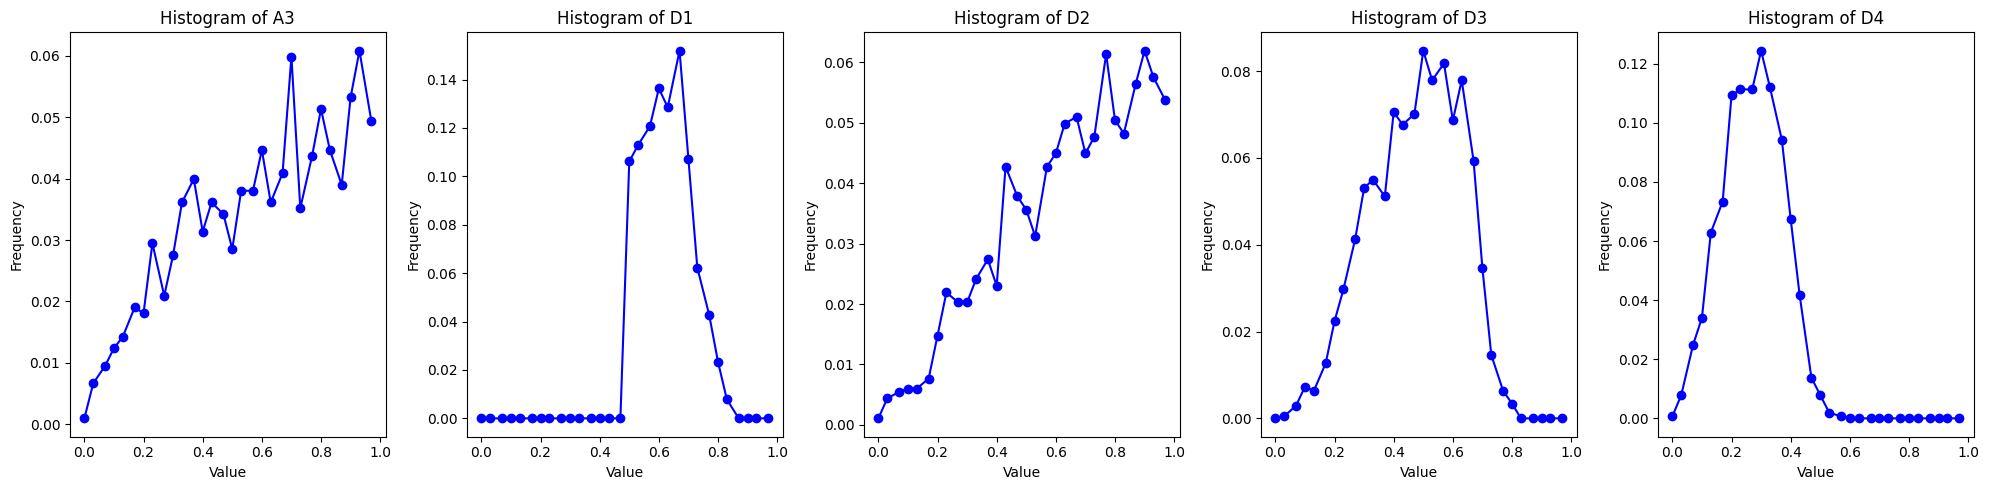

In [3]:
t_range={#Theorethical Range of values
    "A3":(0,np.pi), #Angle Between 3 Points (cos) 
    "D1":(0,np.sqrt(3)), #Worst case scenario very unlikely
    "D2":(0, 3**0.5), #Widest range of the bounding box
    "D3":(0, np.sqrt(1/2*(2**0.5))), #Triangle on the largest rectangle in unit cube, largest rectangle = 1*sqrt(2)
    "D4":(0,(1/3)**(1/3)), #Tetrahedon between maximully separated points (0,0,0),(0,1,1),(1,1,0),(1,0,1), we construct a triangle (0,0,0),(0,1,1),(1,1,0) as the base
    #Sides of length sqrt(2), A=1/2*sqrt(2)*sqrt(2). The point 1,0,1 has distance one from this triangle. i.e 1/3*1/2*sqrt(2)*sqrt(2)
}

print(t_range)


def extract_features(mesh:Mesh):
    cvx = ConvexHull(mesh.vertices)
    diameterRet = get_diameter(mesh,cvx)
    mesh.fill_holes()
    mesh.triangulate()
    ret = {
        "area":mesh.area(),
        "volume":mesh.volume(),
        "rectangularity":get_rectangularity(mesh),
        "compactness":get_compactness(mesh),
        "convexity": get_convexity(mesh,cvx),
        "eccentricity":get_eccentricity(mesh),
        "diameter":diameterRet[0],
        "diameterPts":diameterRet[1],
        "distributions":get_distributions(mesh)
    }
    return ret

# 2 methods to avoid NaN values
def safe_norm(v):
    norm = np.linalg.norm(v)
    if np.isnan(norm) or np.isinf(norm):
        return 0.0  
    return norm

def safe_cross(v1, v2):
    cross_prod = np.cross(v1, v2)
    if np.isnan(cross_prod).any() or np.isinf(cross_prod).any():
        return np.zeros_like(cross_prod) 
    return cross_prod


def subsample_vertices(vertices, num_samples=1000, num_vertices=3):
    N = len(vertices)  
    k = min(num_samples, N // num_vertices)

    sampled_indices = np.random.choice(N, size=(k, num_vertices), replace=False)

    sampled_groups = vertices[sampled_indices]

    return sampled_groups


def get_surface_area(mesh:Mesh):
    return mesh.area()

def get_rectangularity(mesh:Mesh):
    #How close is the shape (post normalisation to its oriented bounding box)
    # (shape volume divided by OBB volume)
    bbox = mesh.bounds()
    Dx = np.abs(bbox[0] - bbox[1])  
    Dy = np.abs(bbox[2] - bbox[3])  
    Dz = np.abs(bbox[4] - bbox[5])  
    obbVol = Dx*Dy*Dz
    rectangularity = mesh.volume()/obbVol
    return rectangularity

def get_compactness(mesh:Mesh):
    #How close is the shape to a sphere
    return mesh.area()**3/(36*np.pi*(mesh.volume()**2))

def get_convexity(mesh:Mesh,cvx:ConvexHull):
    #(shape volume divided by convex hull volume)
    convexity = mesh.volume()/cvx.volume()
    return convexity

def get_diameter(mesh:Mesh,cvx:ConvexHull,k=500):
    maxD = 0
    maxP = [None,None]
    if(len(cvx.vertices)<k):
        subs=cvx.vertices
    else:
        subs = cvx.vertices[np.random.choice(cvx.vertices.shape[0], k, replace=False)]
    for v1 in subs:
        for v2 in cvx.vertices:
            d = np.linalg.norm(v1-v2)
            if d>maxD:
                maxD=d
                maxP = [v1,v2]
    return maxD,maxP        
        
def get_eccentricity(mesh:Mesh):
    #ratio of largest to smallest eigenvalues of covariance matrix
    _,eigval = get_eigenvectors(mesh)
    mineig = min(eigval)
    maxeig = max(eigval)
    return np.abs(maxeig)/np.abs(mineig)

def get_angle_between_vectors(v1, v2):
    #angle between two vectors 
    cos_angle = np.dot(v1, v2) / (np.linalg.norm(v1) * np.linalg.norm(v2))
    return np.arccos(np.clip(cos_angle, -1.0, 1.0))  

def get_hist(desc_vals, bins=10, normalize=True, range=(0,1)):
    hist, bin_edges = np.histogram(desc_vals, bins=bins, density = False, range=range) 
    if normalize:
        hist = hist / np.sum(hist) 
    
    # bin_edges = (bin_edges - np.min(bin_edges)) / (np.max(bin_edges) - np.min(bin_edges))
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])  # Calculate bin centers

    # return hist, bin_centers
    return hist, bin_edges[:-1] 


def get_distributions(mesh:Mesh, show=True):
    num_samples = 100000
    bins = 30

    A3_vals = calc_A3(mesh, num_samples)
    D1_vals = calc_D1(mesh, num_samples)
    D2_vals = calc_D2(mesh, num_samples)
    D3_vals = calc_D3(mesh, num_samples) 
    D4_vals = calc_D4(mesh, num_samples)

    A3_hist, A3_bin_centers = get_hist(A3_vals, bins, t_range["A3"])
    D1_hist, D1_bin_centers = get_hist(D1_vals, bins, t_range["D1"])
    D2_hist, D2_bin_centers = get_hist(D2_vals, bins, t_range["D2"])
    D3_hist, D3_bin_centers = get_hist(D3_vals, bins, t_range["D3"])
    D4_hist, D4_bin_centers = get_hist(D4_vals, bins, t_range["D4"])

    distributions = {
        "A3": (A3_hist, A3_bin_centers),
        "D1": (D1_hist, D1_bin_centers),
        "D2": (D2_hist, D2_bin_centers),
        "D3": (D3_hist, D3_bin_centers),
        "D4": (D4_hist, D4_bin_centers),
    }
    return distributions

def plot_hist(distributions):
    descriptor_names = distributions.keys()  #names
    
    #all histograms here
    fig, axs = plt.subplots(1, len(descriptor_names), figsize=(20, 5))
    
    # Plot each histogram
    for i, name in enumerate(descriptor_names):
        hist, bin_centers = distributions[name]
        data = distributions[name]
        bin_centers = np.round(bin_centers, 2)
        axs[i].plot(bin_centers, hist, marker='o', linestyle='-', color='b')  #
        axs[i].set_title(f"Histogram of {name}")
        axs[i].set_xlabel("Value")
        axs[i].set_ylabel("Frequency")
    
    plt.tight_layout()
    plt.show()

#Calculate distance between the center and a random subset, returns list of euclidian distances
# for D1 max num samples = nr of vertices
def calc_D1(mesh: Mesh, num_samples = 500):
    center = get_center_of_mass(mesh)  
    distances = [safe_norm(vertex - center) for vertex in mesh.vertices]
    return distances

# max num samples  = (nr of vertices)^3
def calc_A3(mesh: Mesh, num_samples = 500):
    # A3 for x(num_samples) number of times for each shape 
    angles = []
    vertices = mesh.vertices
    sampled_triples = subsample_vertices(vertices, num_samples, num_vertices=3) 
    for triple in sampled_triples:
        v1, v2, v3 = triple
        vec1 = v2 - v1
        vec2 = v3 - v1
        if safe_norm(vec1) > 0 and safe_norm(vec2) > 0:
            angle = get_angle_between_vectors(vec1, vec2)
            if not np.isnan(angle) and not np.isinf(angle):
                angles.append(angle)
    return np.array(angles)

# max num samples  = (nr of vertices) ^ 2
def calc_D2(mesh: Mesh, num_samples=500):
    # D2 for x number of times, return concatenated val
    distances = []
    vertices = mesh.vertices
    sampled_duples = subsample_vertices(vertices, num_samples, num_vertices = 2)
    for duple in sampled_duples:
        v1, v2 = duple
        distance = safe_norm(v1 - v2)
        if distance > 0 and not np.isnan(distance) and not np.isinf(distance):
            distances.append(distance)
    return np.array(distances)

# max num samples  = (nr of vertices)^3
def calc_D3(mesh: Mesh, num_samples = 500):
    areas = []
    vertices = mesh.vertices
    sampled_triples = subsample_vertices(vertices, num_samples, num_vertices=3) 
    for triple in sampled_triples:
        v1, v2, v3 = triple
        area = 0.5 * np.linalg.norm(np.cross(v2 - v1, v3 - v1))
        if area > 0 and not np.isnan(area) and not np.isinf(area):
           areas.append(np.sqrt(area))
    return np.array(areas)

# max num samples  = (nr of vertices)^4
def calc_D4(mesh: Mesh, num_samples = 500):
    volumes = []
    vertices = mesh.vertices
    sampled_quadruples = subsample_vertices(vertices, num_samples, num_vertices = 4)
    for q in sampled_quadruples:
        v1, v2, v3, v4 = q
        # volume of tetrahedron
        volume = np.abs(np.dot((v4 - v1), np.cross(v2 - v1, v3 - v1))) / 6
        if volume > 0 and not np.isnan(volume) and not np.isinf(volume):
          volumes.append(np.cbrt(volume))
    return np.array(volumes)

box_features = extract_features(boxMesh)

print("Box:",extract_features(boxMesh))
#print("Sphere:",extract_features(sphereMesh))
#print("Train:",extract_features(train))
#print("Head:",extract_features(head))
#print("Insect:",extract_features(insect))

plot_hist(box_features['distributions'])

    

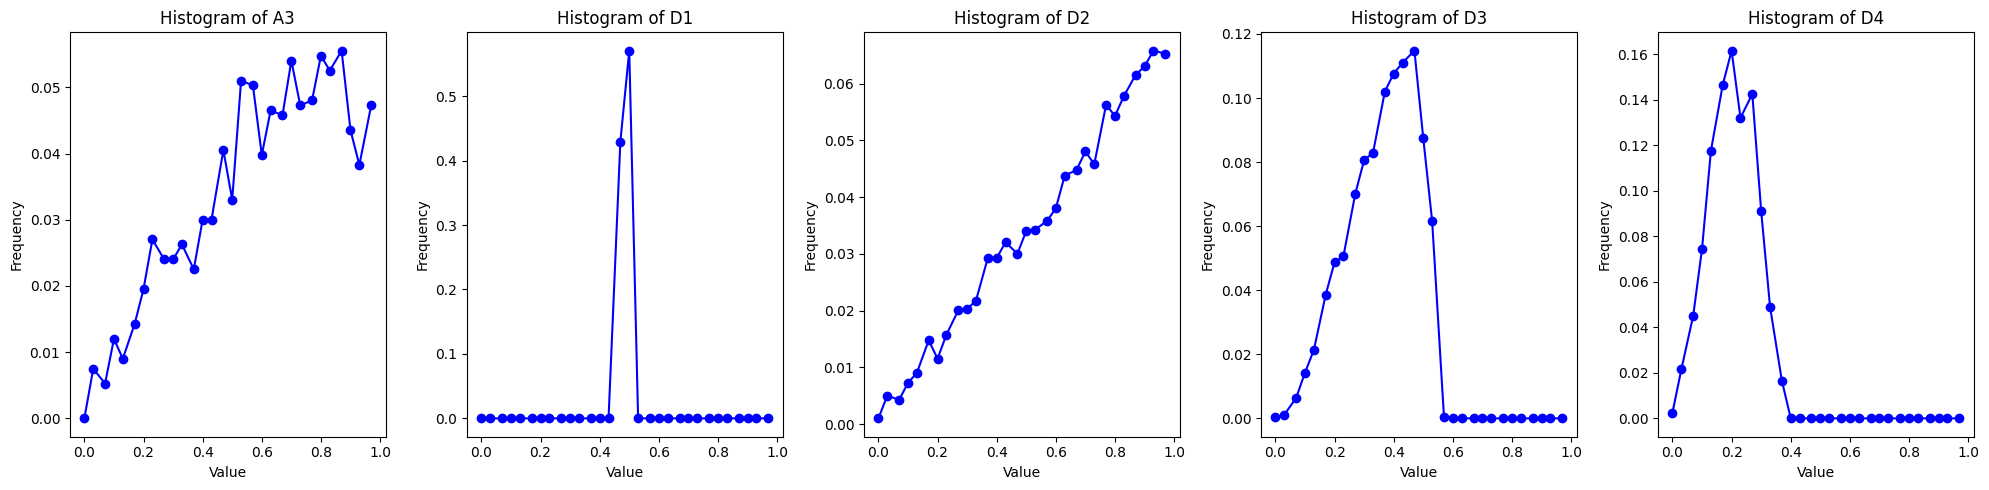

In [4]:
from vedo import Sphere

# Generate a high-resolution sphere
perfect_sphere_mesh = normalize_shape(Sphere(r=1, res= 200, quads=False))
sphere_features = extract_features(perfect_sphere_mesh)

plot_hist(sphere_features['distributions'])

Difficult Calculations
Area - Positive vs Negative (RIght hand rule, counterclockwise orientation = positive, thumb away from screen)
    Solution 1) Ignore sign -> Problem Concave Shapes have "negative" areas -> Areas are overstimated
    Same applies for volume
    Solution 2) Incooperate Sign -> Allow negative areas, concavities are incooperated. Problem: consistent orientation along boundary
    FOr VOlumes check orientation of triangles. -> Get Consistently oriented triangles.

HOle Filling:
Every Edge is shared by two triangles. If an edge has a single edge -> it is a boundary. If you have a boundary loop -> fill. 


In [5]:
print(len(head.vertices))
chull = ConvexHull(head.vertices)
print(len(chull.vertices))

5161
1814


Saving features for each mesh in a csv file , so working with the entire dataset

In [15]:
# this is for the subset dataset

from pathlib import Path
from tqdm import tqdm

df_manifest = pd.read_csv("./subset_shape_manifest.csv")
df_manifest = df_manifest[df_manifest['ReturnCode'] == 0]

def extract_dataset_features_from_shapes(shape_directory="../normshapes", output_file="subset_mesh_features.csv", timeout=60):
    feature_data = []
    skipped = 0
    shape_directory = Path(shape_directory)
    for original_path in tqdm(df_manifest['Path'].apply(Path)):
        class_name = original_path.parent.name
        mesh_file = str(shape_directory / class_name / original_path.name)
        mesh = Mesh(mesh_file)
        
        def process_mesh(mesh):
            return extract_features(mesh)
        
        # Try to extract features with a timeout
        try:
            with concurrent.futures.ThreadPoolExecutor() as executor:
                future = executor.submit(process_mesh, mesh)
                features = future.result(timeout=timeout)  # Set timeout here
            
            feature_row = {
                "mesh_name": original_path.name,  
                "class": class_name,                        
                "area": features["area"],
                "volume": features["volume"],
                "rectangularity": features["rectangularity"],
                "compactness": features["compactness"],
                "convexity": features["convexity"],
                "eccentricity": features["eccentricity"],
                "diameter": features["diameter"]
            }
            
            for dist_name, dist_values in features["distributions"].items():
                    histogram_values = dist_values[0]  # Histogram
                    bin_centers = dist_values[1]  # Bin centers

                # Store histogram values
                    for bin_idx, bin_value in enumerate(histogram_values):
                        feature_row[f"{dist_name}_bin_{bin_idx}"] = bin_value

                # Store bin centers
                    for bin_idx, bin_center in enumerate(bin_centers):
                        feature_row[f"{dist_name}_bin_center_{bin_idx}"] = bin_center

            feature_data.append(feature_row)
        
        except concurrent.futures.TimeoutError:
            # Skip mesh if it takes too long
            print(f"Skipping mesh {os.path.basename(mesh_file)} due to timeout.")
            skipped += 1
        except Exception as e:
            print(f"Error processing mesh {os.path.basename(mesh_file)}: {str(e)}")

    feature_df = pd.DataFrame(feature_data)
    target_directory = os.getcwd()  

    output_path = os.path.join(target_directory, output_file)
    feature_df.to_csv(output_path, index=False)
    print(f"Feature extraction complete. Features saved to {output_path}.")
    print("Skipped meshes count: " + str(skipped))


extract_dataset_features_from_shapes(shape_directory="../normshapes", output_file="subset_mesh_features.csv")


  0%|          | 0/396 [00:00<?, ?it/s]

100%|██████████| 396/396 [21:15<00:00,  3.22s/it]


Feature extraction complete. Features saved to /home/pcsmet/University/Period1Y2/INFOMR-final-project/mmdbs/subset_mesh_features.csv.
Skipped meshes count: 0


In [85]:
# this is only for a few meshes from each class just for plotting
def extract_dataset_features_from_shapes(shape_directory="shapes", output_file="all_class_mesh_features.csv", allowed_classes=None, max_meshes_per_class=20, timeout=60):
    feature_data = []
    skipped = 0

    allowed_classes = allowed_classes or os.listdir(shape_directory)

    for class_name in os.listdir(shape_directory):
        class_path = os.path.join(shape_directory, class_name)
        
        
        if allowed_classes and class_name not in allowed_classes:
            print(f"Skipping class {class_name} as it is not in the allowed classes list.")
            continue
        
        if os.path.isdir(class_path):
            mesh_files = glob(os.path.join(class_path, '*.obj'))

            if len(mesh_files) > max_meshes_per_class:
                mesh_files = mesh_files[:max_meshes_per_class]  

            for mesh_file in mesh_files:
                mesh = normalize_shape(Mesh(mesh_file))
                
                def process_mesh(mesh):
                    return extract_features(mesh)
                
                try:
                    with concurrent.futures.ThreadPoolExecutor() as executor:
                        future = executor.submit(process_mesh, mesh)
                        features = future.result(timeout=timeout)  
                    
                    feature_row = {
                        "mesh_name": os.path.basename(mesh_file),  
                        "class": class_name,                        
                        "area": features["area"],
                        "volume": features["volume"],
                        "rectangularity": features["rectangularity"],
                        "compactness": features["compactness"],
                        "convexity": features["convexity"],
                        "eccentricity": features["eccentricity"],
                        "diameter": features["diameter"]
                    }
        
                    for dist_name, dist_values in features["distributions"].items():
                         print(dist_values)
                         histogram_values = dist_values[0]  # Histogram
                         bin_centers = dist_values[1]  # Bin centers

                     # Store histogram values
                         for bin_idx, bin_value in enumerate(histogram_values):
                             feature_row[f"{dist_name}_bin_{bin_idx}"] = bin_value
                             print(f"{dist_name}_bin_{bin_idx}")

                     # Store bin centers
                         for bin_idx, bin_center in enumerate(bin_centers):
                              feature_row[f"{dist_name}_bin_center_{bin_idx}"] = bin_center
                              print(f"{dist_name}_bin_center_{bin_idx}")
                    
                    feature_data.append(feature_row)
                    print('Feature row added for mesh: ' + os.path.basename(mesh_file))
                
                except concurrent.futures.TimeoutError:
                    # Skip if it takes too long
                    print(f"Skipping mesh {os.path.basename(mesh_file)} due to timeout.")
                    skipped += 1
                except Exception as e:
                    print(f"Error processing mesh {os.path.basename(mesh_file)}: {str(e)}")

    feature_df = pd.DataFrame(feature_data)
    target_directory = os.getcwd()  

    output_path = os.path.join(target_directory, output_file)
    feature_df.to_csv(output_path, index=False)
    print(f"Feature extraction complete. Features saved to {output_path}.")
    print("Skipped meshes count: " + str(skipped))

extract_dataset_features_from_shapes(
    shape_directory="../shapes", 
    output_file="all_mesh_features.csv", 
    allowed_classes=[ "Car" , "Drum" , "Fish", "Guitar" , "Rocket" , "Ship" , "Sword" , "Tool" , "Truck" , "Vase" , "Wheel"], 
    max_meshes_per_class=30
)

Skipping class Insect as it is not in the allowed classes list.
Skipping class Bookset as it is not in the allowed classes list.
Skipping class Tree as it is not in the allowed classes list.
Skipping class RectangleTable as it is not in the allowed classes list.
(array([0.24750499, 0.13722555, 0.07035928, 0.0499002 , 0.03443114,
       0.02744511, 0.01746507, 0.01846307, 0.01447106, 0.01247505,
       0.01147705, 0.00948104, 0.01197605, 0.01047904, 0.00598802,
       0.00898204, 0.00998004, 0.00698603, 0.00598802, 0.01097804,
       0.00998004, 0.01147705, 0.00848303, 0.01846307, 0.02644711,
       0.02744511, 0.03692615, 0.0489022 , 0.0508982 , 0.03892216]), array([0.        , 0.1045437 , 0.20908741, 0.31363111, 0.41817481,
       0.52271851, 0.62726222, 0.73180592, 0.83634962, 0.94089332,
       1.04543703, 1.14998073, 1.25452443, 1.35906813, 1.46361184,
       1.56815554, 1.67269924, 1.77724294, 1.88178665, 1.98633035,
       2.09087405, 2.19541775, 2.29996146, 2.40450516, 2.5090488

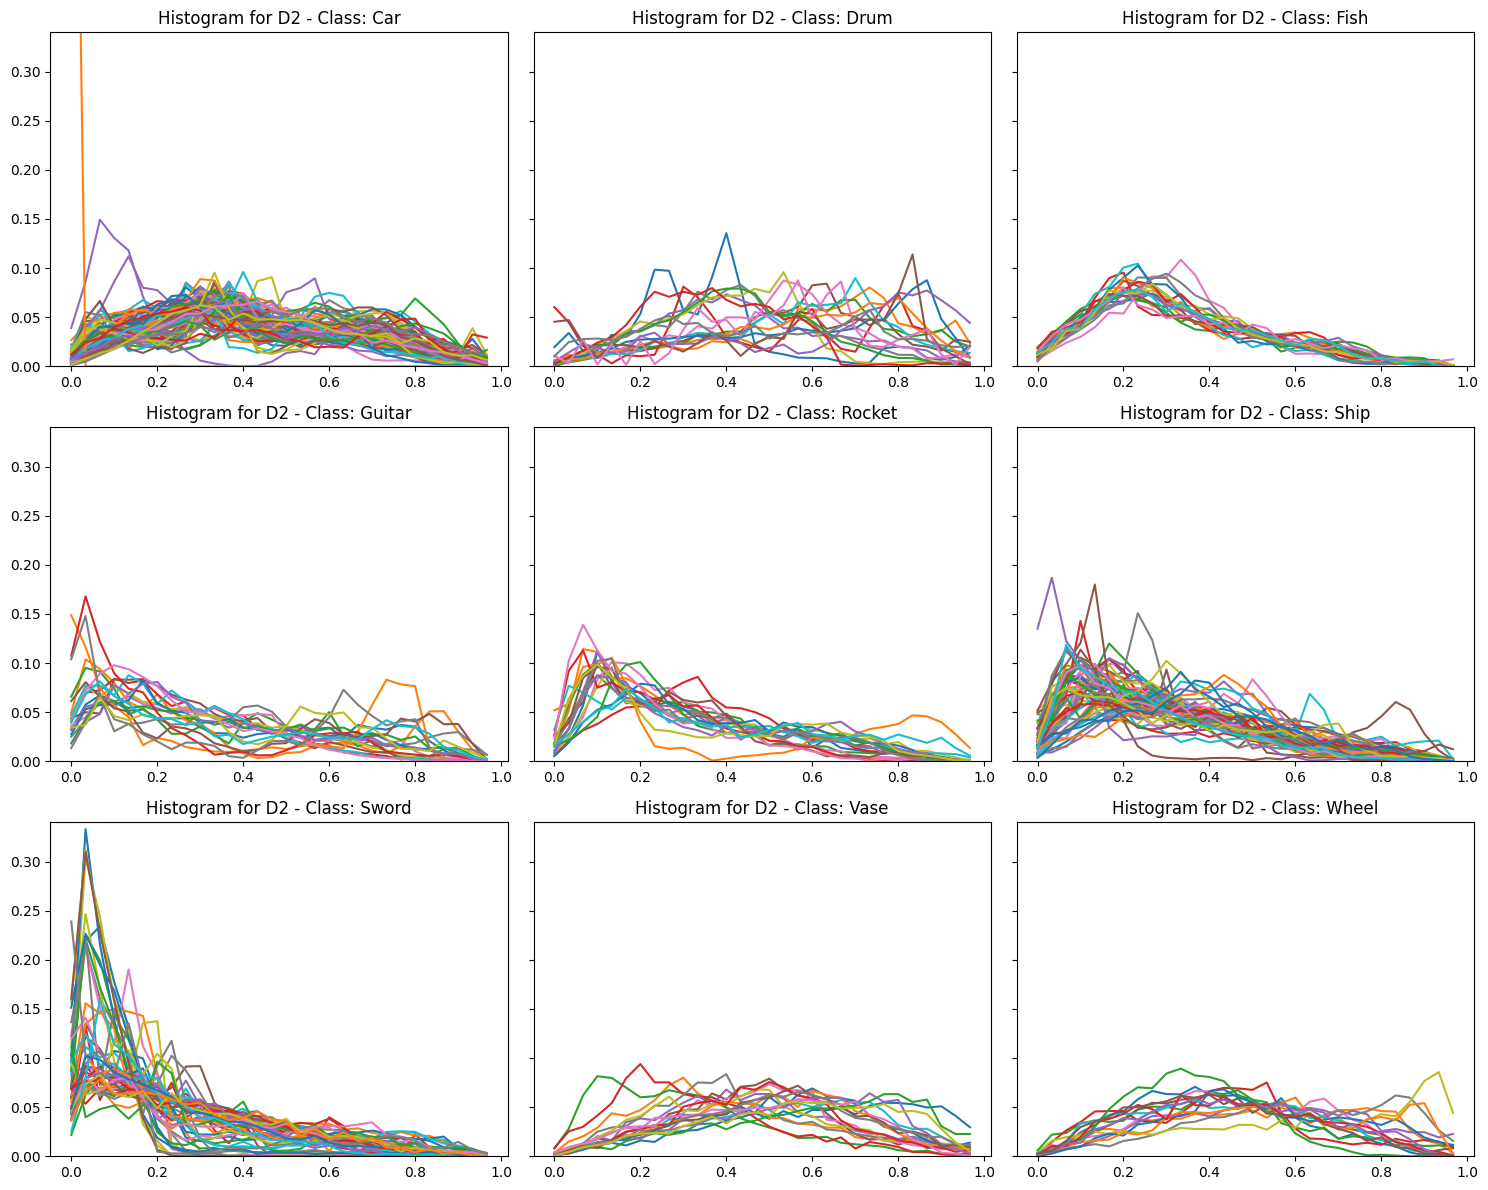

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

def load_features(file_path):
    return pd.read_csv(file_path)

# 3x3 figure with the histograms
def plot_histograms_for_classes(feature_df, descriptor_name, selected_classes):
    filtered_df = feature_df[feature_df['class'].isin(selected_classes)]
    fig, axes = plt.subplots(3, 3, figsize=(15, 12), sharey=True)
    axes
    
    axes = axes.flatten()

    for i, class_name in enumerate(selected_classes):
        class_df = filtered_df[filtered_df['class'] == class_name]
        ax = axes[i]  
        ax.set_ylim(0, 0.34)

        ax.set_title(f'Histogram for {descriptor_name} - Class: {class_name}')

        for idx, row in class_df.iterrows():

            histogram_values = [row[f"{descriptor_name}_bin_{j}"] for j in range(30)]  
            bin_centers = [row[f"{descriptor_name}_bin_center_{j}"] for j in range(30)]

            ax.plot(bin_centers, histogram_values)
    
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    features_file = "mesh_features.csv"  
    feature_df = load_features(features_file)
    
    selected_classes = [ "Car", "Drum", "Fish", "Guitar", "Rocket", "Ship", "Sword", "Vase", "Wheel"]
    
    descriptor_name = "D2"

    plot_histograms_for_classes(feature_df, descriptor_name, selected_classes)

